# A deeper look at linear regression basic functionality

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from ya_glm.toy_data import sample_sparse_lin_reg

In [2]:
# toy sparse linear regression data
X, y = sample_sparse_lin_reg(n_samples=100, n_features=10, n_nonzero=5,
                             random_state=234)[0:2]

# A single Estimator

In [3]:
from ya_glm.models.Lasso import Lasso

In [4]:
# take a look at the possible parameter optoins
Lasso.__init__

<function ya_glm.models.Lasso.Lasso.__init__(self, loss='lin_reg', fit_intercept=True, pen_val=1, lasso_weights=None, groups=None, multi_task=False, nuc=False, ridge_pen_val=None, ridge_weights=None, tikhonov=None, standardize=False, solver='default')>

### specifying the penalty

In [5]:
# set the penalty parameter value
est = Lasso(pen_val=.4)

# weighted lasso penalty
est = Lasso(lasso_weights=np.arange(X.shape[1]))

# add ridge penalty with  tikhonov matrix
tikhonov = np.ones((X.shape[1], X.shape[1]))
est = Lasso(ridge_pen_val=2, tikhonov=tikhonov)

### other fitting options

In [6]:
# turn off the intercept
est = Lasso(fit_intercept=False)

In [7]:
# We typically want each variable to be on the same scale 
# so we can "interally standardize the data before fitting,
# which means we mean center and scale the variables
est = Lasso(standardize=True)

# note "internally standardize" means the fitting coefficient/intercept is put back
# on the scale of the data 

### User specified groups

In [8]:
# you can specify groups for the group lasso
groups = [range(5), range(5, 10)]
est = Lasso(groups=groups)

# when we standardize the group lasso we
# center each variable, scale by the standard deviation,
# then rescale the variables again by the inverse square root of the group sizes 
est = Lasso(groups=groups, standardize=True)

# specifying the optimzation algorithm

In [9]:
from ya_glm.solver.FistaSolver import FistaSolver

In [10]:
# we can specify the optimzation algorithm by providing 
# a solver config object
est = Lasso(solver=FistaSolver(max_iter= 200, atol=1e-5))

# A cross-validation estimator

In [11]:
from ya_glm.models.Lasso import LassoCV

In [12]:
# take a look at the possible parameter optoins
LassoCV.__init__

<function ya_glm.models.Lasso.LassoCV.__init__(self, estimator=Lasso(), cv=None, cv_select_rule='best', cv_select_metric=None, cv_scorer=None, cv_verbose=0, cv_n_jobs=None, cv_pre_dispatch='2*n_jobs', n_pen_vals=100, pen_vals=None, pen_min_mult=0.001, pen_spacing='log')>

In [13]:
# the CV object takes an estimator as input
# we specify parameters of the lasso fit in the estimator
# you can specify anything except estimator parameter except pen_val
est = Lasso(fit_intercept=False)

# the cross-validation object controls how cross-validation is performed
est_cv = LassoCV(estimator=est,
                 cv=10, cv_n_jobs=-1, # number of folds, parallelization
                 
                 cv_select_rule='1se', # 1se rule for tuning parameter selection
                 
                 n_pen_vals=200 # number of values in automatically generated tuning sequence
                 
                 # but you can specify the tuning sequence by hand if you want
                 # pen_vals=np.linspace(start=0, stop=1, num=20)
                 )
est_cv.fit(X, y)
est_cv.best_estimator_

Lasso(fit_intercept=False, pen_val=0.24369964632709046)

### automatically specifying the tuning parameter sequence

We generate the tuning parameter sequence following standard packages ([glmnet](https://glmnet.stanford.edu/articles/glmnet.html#commonly-used-function-arguments-1), [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)).

- For each loss + penalty combination we first determine the `pen_val_max` such that larget penalty values will always return 0 for a given dataset.

- The penalty sequence then lives in the interval [`pen_min_mult` `pen_val_max`, `pen_val_max`] where `pen_min_mult` is some small value e.g. 1e-3.

- The penalty sequence is ether generated with logarithmically spaced values (i.e. more values near 0) or linearly.


**We take care of this for any loss + penalty combination, including concave penalties!**

Text(0.5, 0, 'Index')

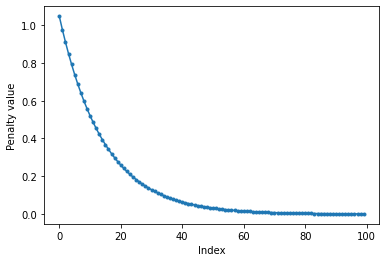

In [14]:
est_cv = LassoCV(pen_min_mult=1e-3,
                 n_pen_vals=100,
                 pen_spacing='log' # 'lin'
                )

est_cv._set_tuning_values(X=X, y=y) # this gets called on the backend
plt.plot(est_cv.pen_val_seq_, marker='.')
plt.ylabel("Penalty value")
plt.xlabel("Index")

In [15]:
# On the backend each estimator object knows how to compute the pen_val_max
est = Lasso()
print(est.get_pen_val_max(X, y))

# the get_pen_val_max() function computes the pen_val_max for the data the optimzation
# algorithm actually sees and knows about the intercept.
est = Lasso(fit_intercept=False, standardize=True)

print(est.get_pen_val_max(X, y)) # this is slightly different that above!

1.0466937013461965
1.02829585494881


### cross-validation visualization 

In [16]:
from ya_glm.cv.cv_viz import plot_cv_path, plot_cv_two_params
from ya_glm.models.ENet import ENetCV

In [17]:
# the CV results are stored in a cv_results_ dict just as in sklearn's GridSeachCV object
est_cv.fit(X, y)
type(est_cv.cv_results_)

dict

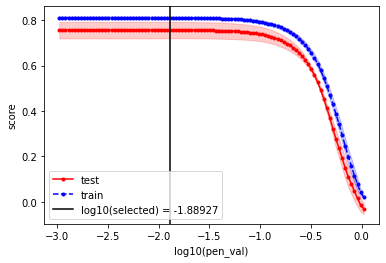

In [18]:
# we provide some basic CV visualization diagnostics 
plot_cv_path(est_cv.cv_results_, metric='score',
             log_param=True,
             selected_idx=est_cv.best_tune_idx_)

In [19]:
# we also include visualizations for ElasticNet 
# tuned over both the l1_ratio and pen_val
est_cv = ENetCV(l1_ratio='tune').fit(X, y)

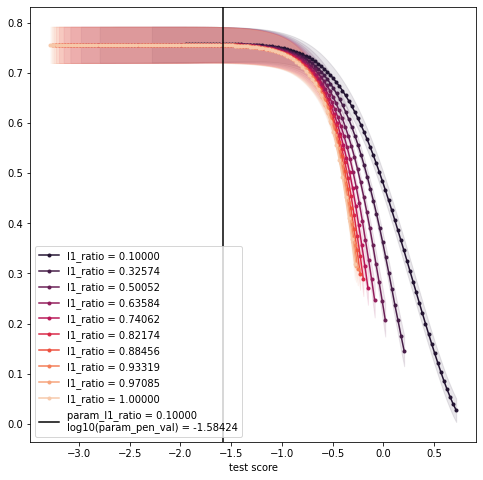

In [20]:
plt.figure(figsize=(8, 8))
plot_cv_two_params(est_cv.cv_results_, param='pen_val', group_param='l1_ratio',
                  log_param=True,
                   selected_idx=est_cv.best_tune_idx_)

### Custom CV metrics

In [22]:
from ya_glm.CvScoring import LinRegScorer

In [23]:
# each model comes its own Scorer class, but you can create your own
LinRegScorer.__init__ 

<function ya_glm.CvScoring.LinRegScorer.__init__(self, level=1, default='r2')>

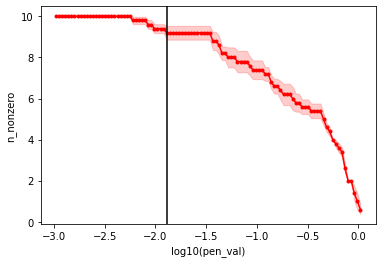

In [25]:
est_cv = LassoCV(cv_scorer=LinRegScorer(level=2)# compute more data
                ).fit(X, y)

# for exapmle we can track the number of non-zero coefficient values 
plot_cv_path(est_cv.cv_results_, metric='n_nonzero',
             log_param=True, show_train=False,
             selected_idx=est_cv.best_tune_idx_)